In [1]:
from scipy.io import loadmat
import pandas as pd
from matplotlib import pyplot
mat = loadmat('Xtrain.mat')

In [3]:
mdata = mat['Xtrain']
series = pd.DataFrame(mdata, columns={"t"})
series

,t
0,86
1,141
2,95
3,41
4,22
...,...
995,61
996,20
997,12
998,13


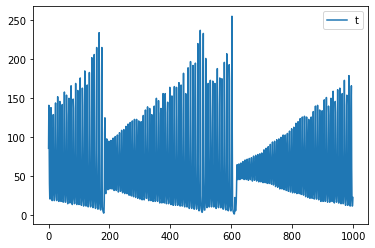

In [4]:
series.plot()

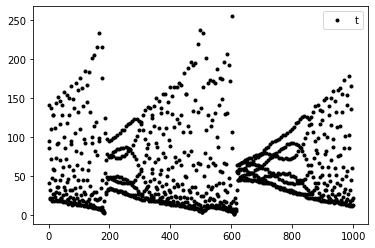

In [5]:
series.plot(style='k.')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FC2AFCC5C8>]],
      dtype=object)

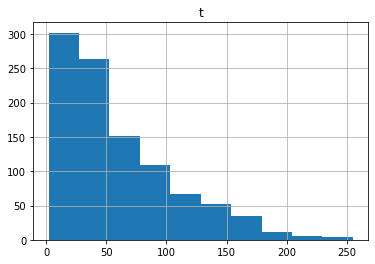

In [6]:
series.hist()

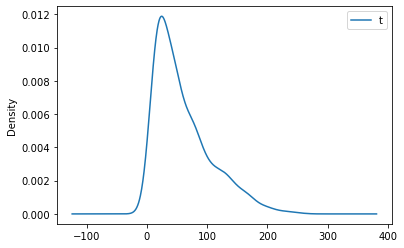

In [7]:
series.plot(kind='kde')

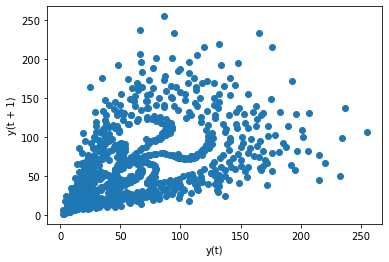

In [8]:
from pandas.plotting import lag_plot
lag_plot(series)

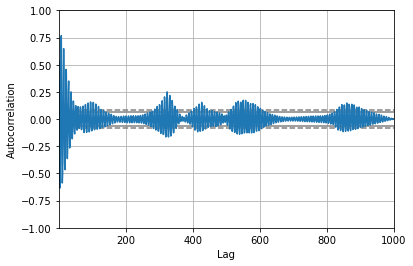

In [9]:
# The resulting plot shows lag along the x-axis and the correlation on the y-axis. 
# Dotted lines are provided that indicate any correlation values above those lines are statistically significant (meaningful).

# Correlation with lag across the x-axis (lag is the past observations, lag1 is the previous, lag2 is two back and so on.....)
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)

In [47]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
number_lag  = 1
data = series_to_supervised(mdata, number_lag)
print(data)

     var1(t-1)  var1(t)
1         86.0      141
2        141.0       95
3         95.0       41
4         41.0       22
5         22.0       21
..         ...      ...
995      166.0       61
996       61.0       20
997       20.0       12
998       12.0       13
999       13.0       23

[999 rows x 2 columns]


In [58]:
X = data[[col for col in data.columns if col != 'var1(t)']]
Y = data['var1(t)']

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X, Y, test_size=0.2, random_state=23)
# take the remaining 20% of data in X_tmp, y_tmp and split them evenly
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=23)

#X_train.shape, X_test.shape, X_val.shape
print("Training instances   {}".format(X_train.shape[0]))
print("Validation instances {}".format(X_val.shape[0]))
print("Testing instances    {}".format(X_test.shape[0]))

Training instances   799
Validation instances 100
Testing instances    100


In [60]:
import tensorflow as tf
feature_cols = [tf.feature_column.numeric_column(col) for col in X.columns]

NameError: name 'tf' is not defined

In [ ]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,
                                      hidden_units=[50, 50],
                                      model_dir='tf_wx_model')

In [ ]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=400):
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)